In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix

In [71]:
df = pd.read_csv("./Datasets/stations_cleaned_sample.csv")
originalColumns = df.columns.tolist()
df.shape

(1611, 21)

In [72]:
df.sample(10)

,station_code,monitoring_location,state_name,temp_min,temp_max,do_min,do_max,ph_min,ph_max,conductivity_min,...,bod_min,bod_max,nitrate_min,nitrate_max,fecal_coliform_min,fecal_coliform_max,total_coliform_min,total_coliform_max,fecal_streptococci_min,fecal_streptococci_max
272,3114,"RIVER GANGA NEAR DANAPUR (NEAR PIPA PUL) ,PATNA",BIHAR,13.0,33.0,6.8,9.9,7.2,8.4,268.0,...,1.0,2.2,0.30,0.34,1100.0,54000.0,1400.0,92000.0,2.0,490.0
107,2605,RIVER PARVATI AT U/S MANIKARAN,HIMACHAL PRADESH,3.0,15.0,7.2,8.8,6.8,8.3,40.0,...,1.0,1.0,0.32,1.06,17.0,47.0,63.0,220.0,2.0,2.0
559,2565,RIVER KOSHI AT KURSHELA AT KATIHAR,BIHAR,16.0,29.0,7.0,9.3,7.0,8.4,137.0,...,1.0,2.5,0.30,0.30,1700.0,92000.0,2200.0,160000.0,NaN,NaN
551,4300,"RIVER BURHI GANDAK AT LAL BAGLA GHAT, MOTIHARI...",BIHAR,20.0,31.0,6.2,8.9,7.3,8.0,218.0,...,1.0,3.0,0.30,0.30,2300.0,35000.0,4600.0,92000.0,NaN,NaN
426,3832,RIVER BETWA AT U/S NEAR ROAD BRIDGE ORCHHA,MADHYA PRADESH,19.0,32.0,7.2,9.2,7.6,7.9,266.0,...,1.0,2.1,0.33,0.36,2.0,2.0,26.0,49.0,2.0,2.0
963,1222,RIVER SHEDHI AT KHEDA,GUJARAT,28.0,35.0,4.5,7.2,7.7,8.5,460.0,...,1.0,2.7,1.12,7.94,50.0,1600.0,300.0,1600.0,2.0,540.0
59,4033,RIVER SUTLEJ NEAR LUHNOO GROUND,HIMACHAL PRADESH,10.0,33.0,8.1,8.9,6.8,8.3,150.0,...,1.0,2.8,0.39,3.50,33.0,1600.0,240.0,1600.0,2.0,2.0
1442,5594,RIVER TUNGABHADRA AT KONANATHAMBIGE,KARNATAKA,27.0,32.0,7.0,10.5,7.6,8.4,136.0,...,1.0,3.6,0.65,1.41,18.0,140.0,170.0,1400.0,NaN,NaN
228,5708,"RIVER GANGA TIGRI GANGA GHAT, VILLAGE-TIGARI, ...",UTTAR PRADESH,8.4,8.9,7.7,7.9,241.0,252.0,1.2,...,0.0,0.0,460.00,790.00,1300.0,1700.0,2.0,2.0,NaN,NaN
68,30010,RIVER SUTLEJ AT NOORPUR BEDI ROAD (PUNJAB),PUNJAB,19.5,24.0,7.1,9.8,7.7,8.3,257.0,...,1.0,5.0,0.32,1.10,200.0,13000.0,1700.0,350000.0,130.0,700.0


In [73]:
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

In [74]:
df.columns

Index(['station_code', 'monitoring_location', 'state_name', 'temp_min',
       'temp_max', 'do_min', 'do_max', 'ph_min', 'ph_max', 'conductivity_min',
       'conductivity_max', 'bod_min', 'bod_max', 'nitrate_min', 'nitrate_max',
       'fecal_coliform_min', 'fecal_coliform_max', 'total_coliform_min',
       'total_coliform_max', 'fecal_streptococci_min',
       'fecal_streptococci_max'],
      dtype='object')

In [75]:
turb_cols = [c for c in df.columns if "turbid" in c or c.endswith("ntu") or c == "turbidity"]
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

In [76]:
df.drop_duplicates(inplace=True)

In [77]:
df.isna().sum()

station_code                0
monitoring_location         6
state_name                124
temp_min                    7
temp_max                    8
do_min                      8
do_max                      8
ph_min                      8
ph_max                      8
conductivity_min            8
conductivity_max            8
bod_min                     8
bod_max                     8
nitrate_min                56
nitrate_max                56
fecal_coliform_min        184
fecal_coliform_max        185
total_coliform_min        224
total_coliform_max        224
fecal_streptococci_min    766
fecal_streptococci_max    767
dtype: int64

In [78]:
summary = {
    "rows": len(df),
    "cols": len(df.columns),
    "original_columns": originalColumns,
    "normalized_columns": df.columns.tolist(),
    "candidate_turbidity_columns": turb_cols,
    "numeric_columns_count": len(numeric_cols)
}

In [79]:
schema_report = pd.DataFrame({
    "column": df.columns,
    "dtype": [str(df[c].dtype) for c in df.columns],
    "non_null": [df[c].notna().sum() for c in df.columns],
    "nulls": [df[c].isna().sum() for c in df.columns],
    "unique": [df[c].nunique(dropna=True) for c in df.columns]
})
schema_report

,column,dtype,non_null,nulls,unique
0,station_code,int64,1605,0,1604
1,monitoring_location,object,1599,6,1598
2,state_name,object,1481,124,116
3,temp_min,float64,1598,7,149
4,temp_max,float64,1597,8,164
5,do_min,float64,1597,8,101
6,do_max,float64,1597,8,115
7,ph_min,float64,1597,8,77
8,ph_max,float64,1597,8,78
9,conductivity_min,float64,1597,8,569


In [80]:
df.isna().sum()

station_code                0
monitoring_location         6
state_name                124
temp_min                    7
temp_max                    8
do_min                      8
do_max                      8
ph_min                      8
ph_max                      8
conductivity_min            8
conductivity_max            8
bod_min                     8
bod_max                     8
nitrate_min                56
nitrate_max                56
fecal_coliform_min        184
fecal_coliform_max        185
total_coliform_min        224
total_coliform_max        224
fecal_streptococci_min    766
fecal_streptococci_max    767
dtype: int64

In [81]:
df['state_name'].dropna(inplace=True)

In [82]:
df.isna().sum()

station_code                0
monitoring_location         6
state_name                124
temp_min                    7
temp_max                    8
do_min                      8
do_max                      8
ph_min                      8
ph_max                      8
conductivity_min            8
conductivity_max            8
bod_min                     8
bod_max                     8
nitrate_min                56
nitrate_max                56
fecal_coliform_min        184
fecal_coliform_max        185
total_coliform_min        224
total_coliform_max        224
fecal_streptococci_min    766
fecal_streptococci_max    767
dtype: int64

In [83]:
missing = df[pd.isna(df['fecal_coliform_min'])]

In [84]:
for c in ['nitrate_min', 'nitrate_max', 'fecal_coliform_min', 'fecal_coliform_max', 'total_coliform_min', 'total_coliform_max']:
    df[c+"missing"] = df[c].isna().astype(int)
    df[c] = df[c].fillna(df[c].median())

In [85]:
df.drop(columns=["fecal_streptococci_min","fecal_streptococci_max"], inplace=True)

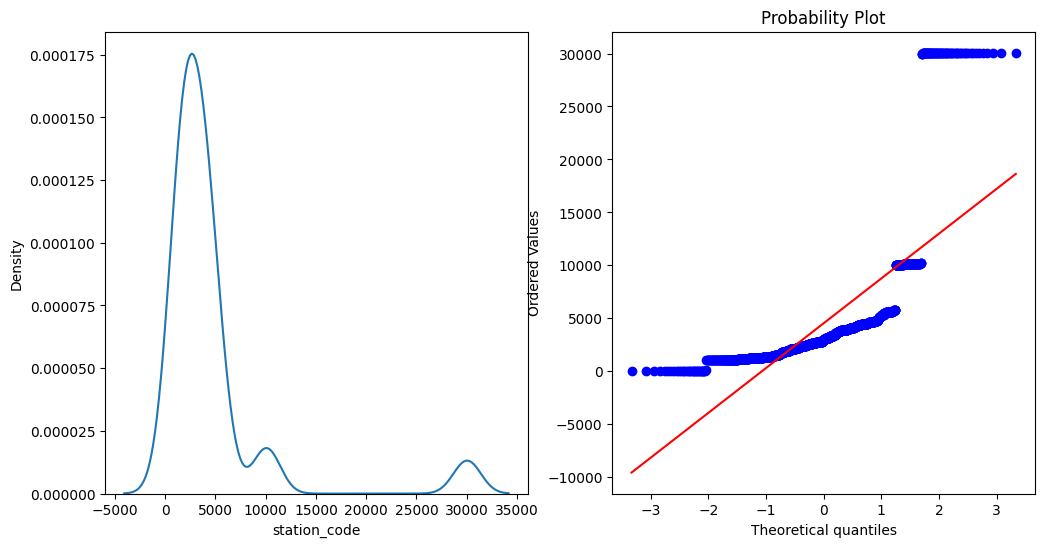

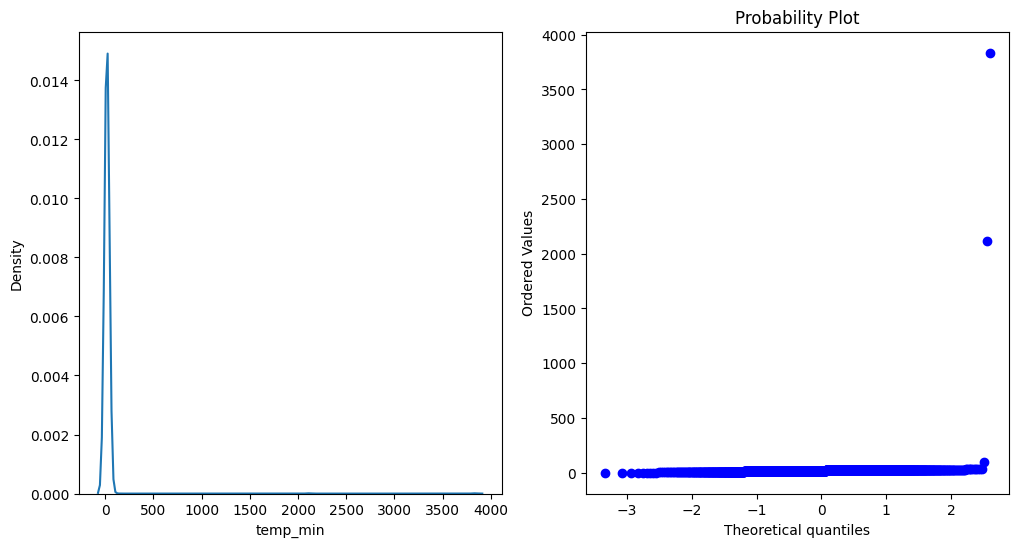

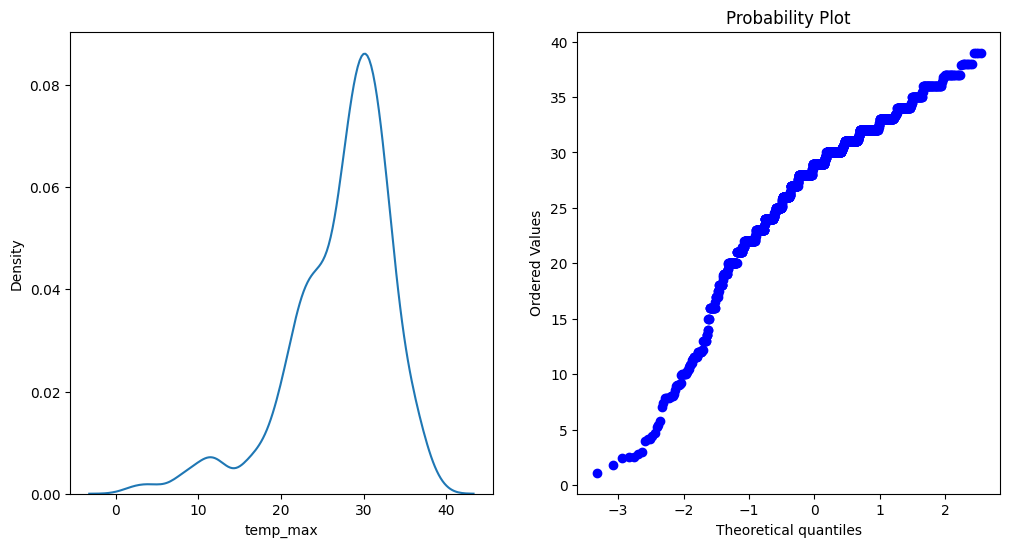

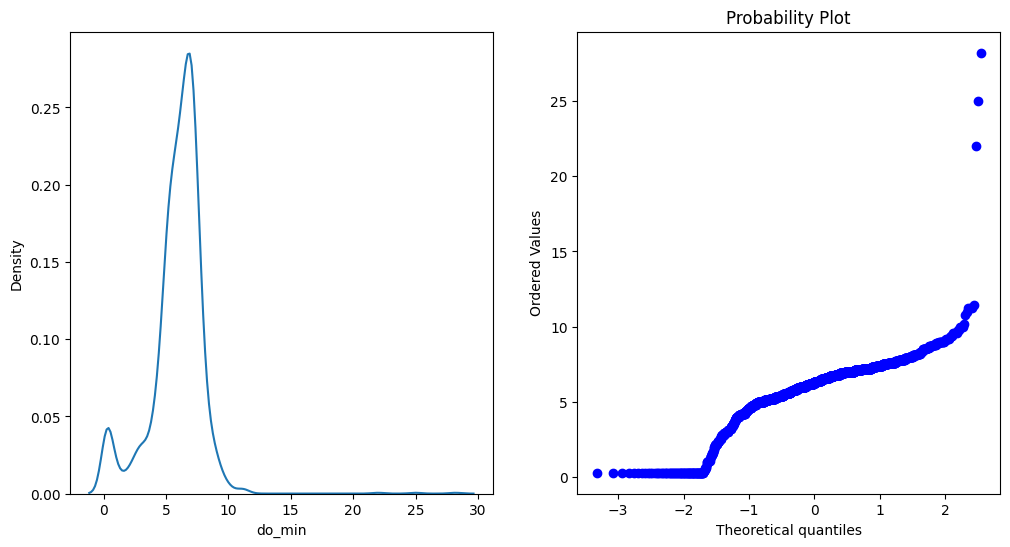

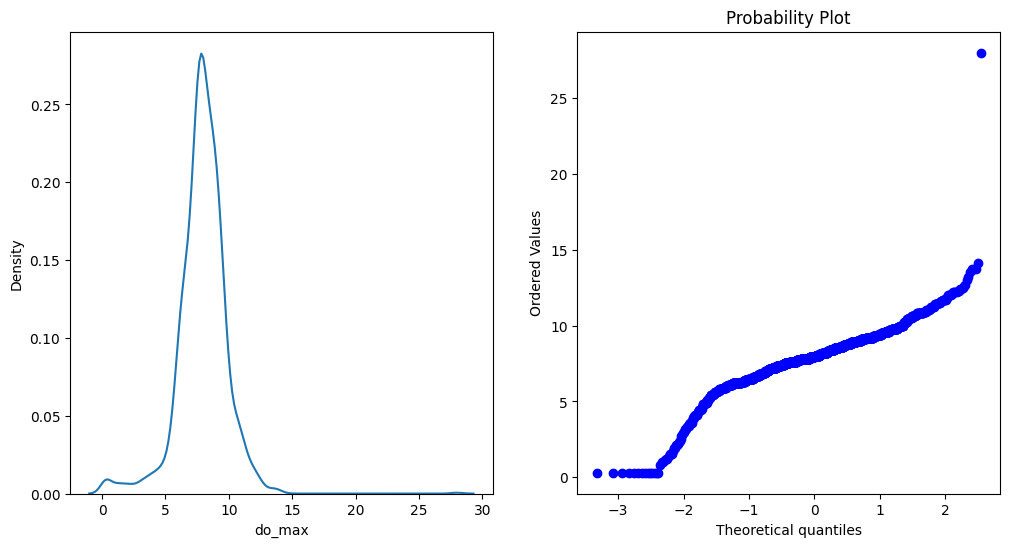

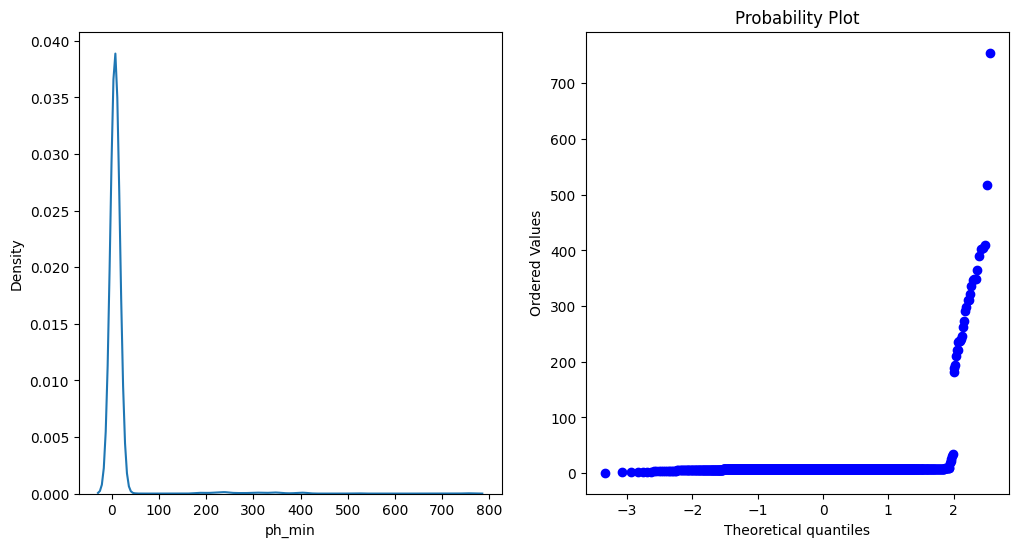

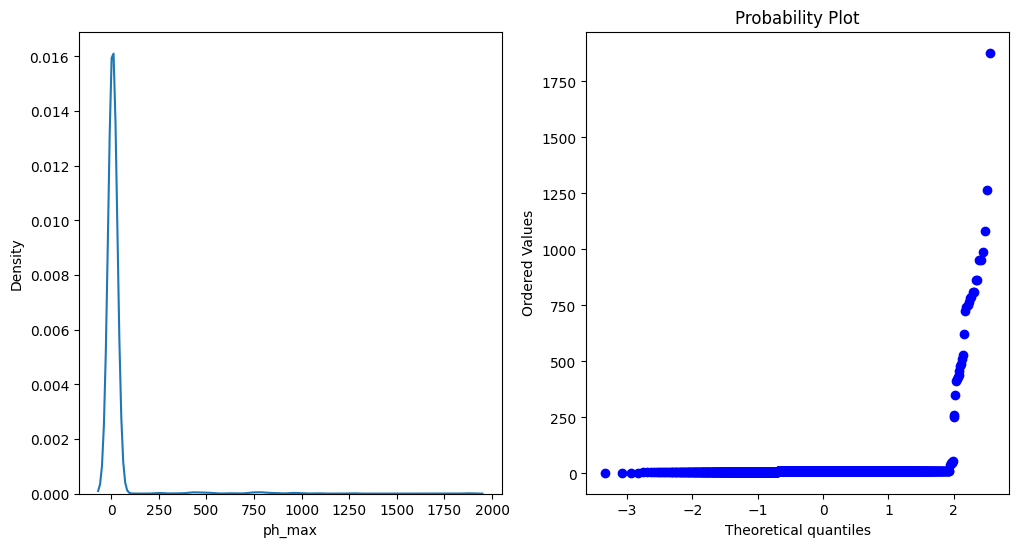

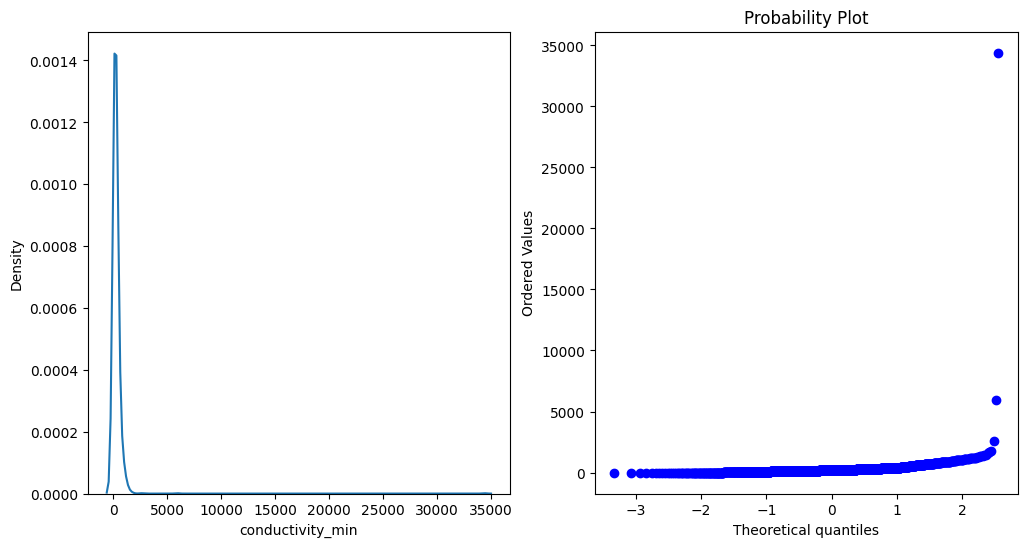

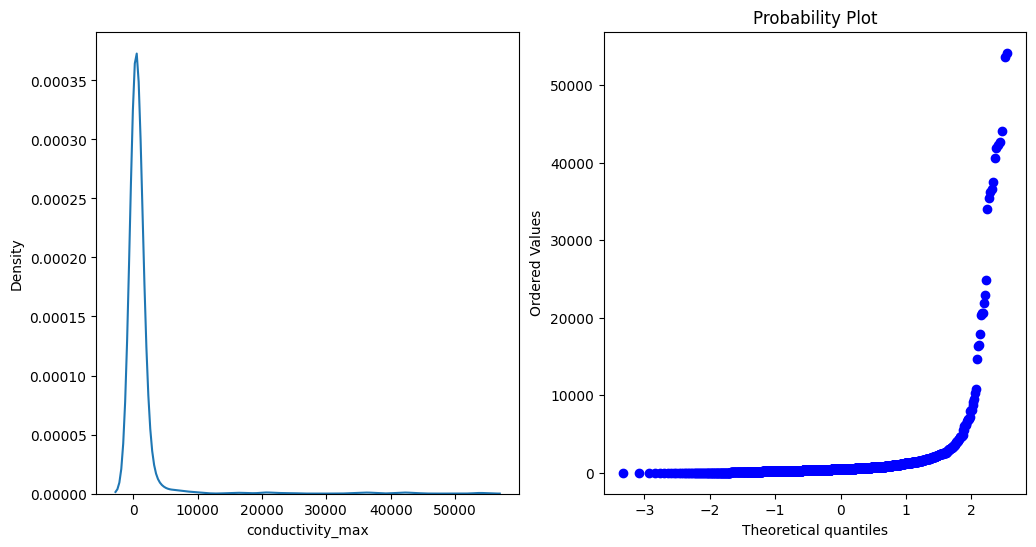

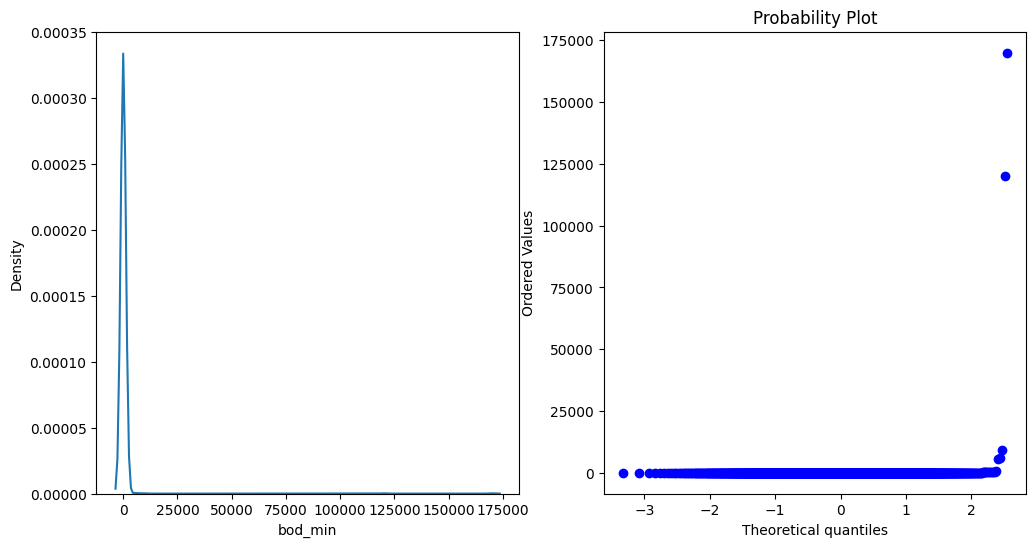

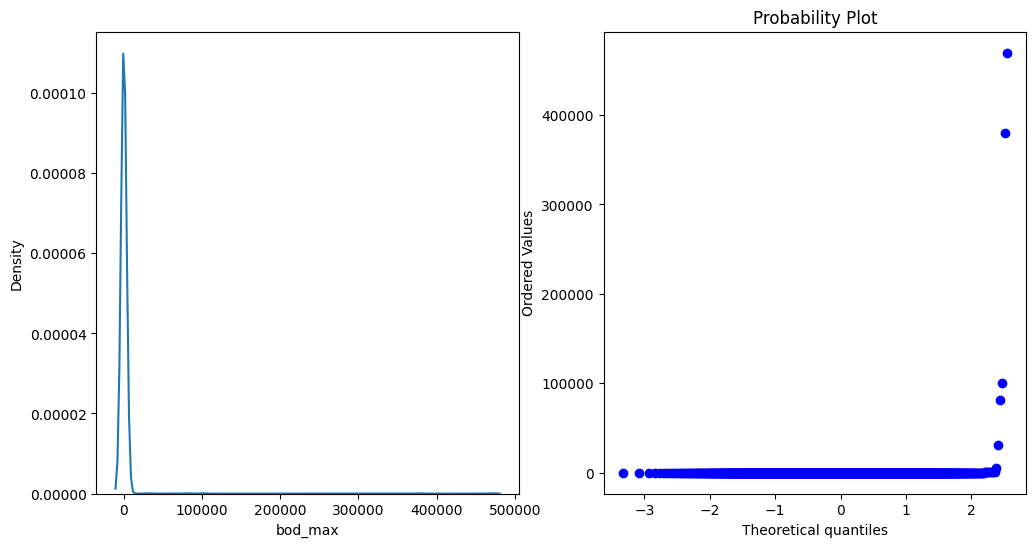

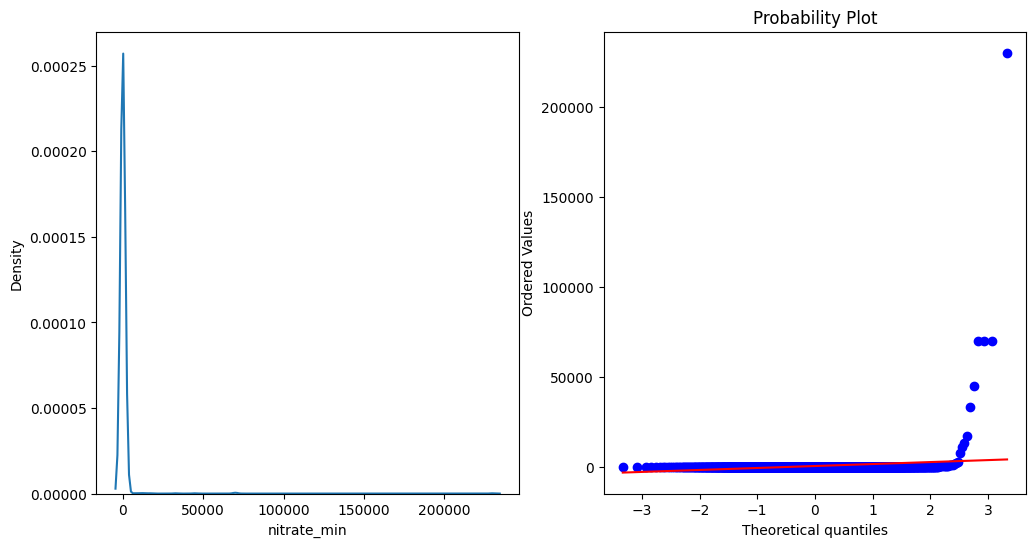

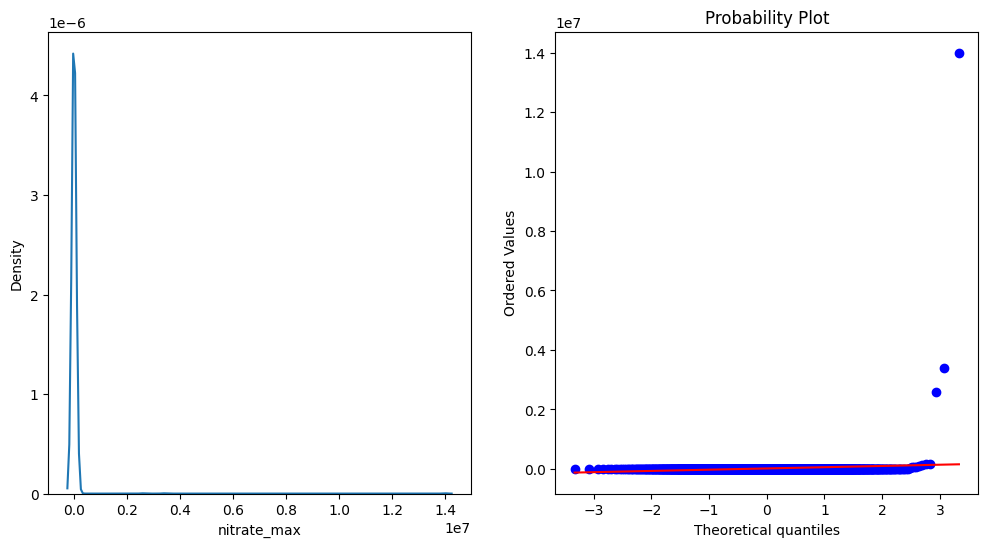

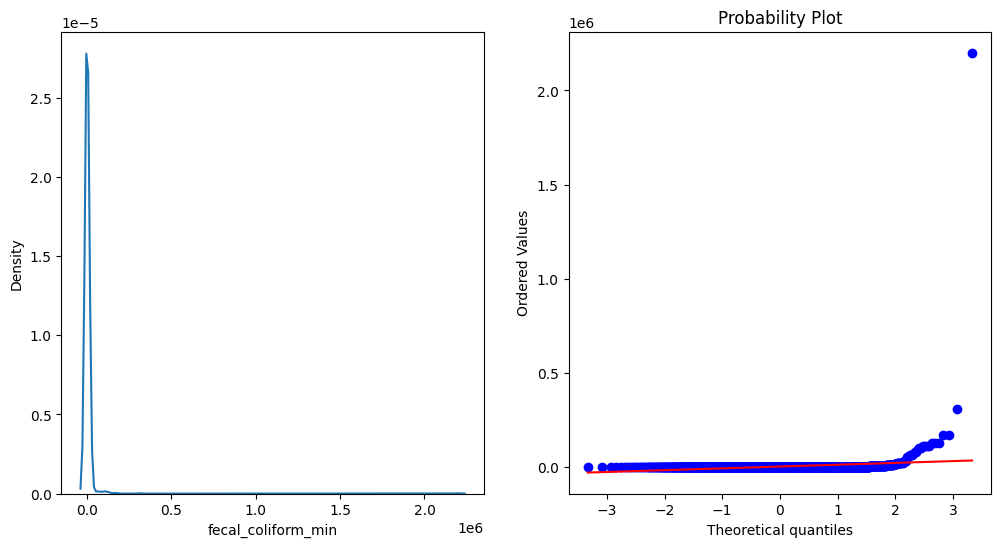

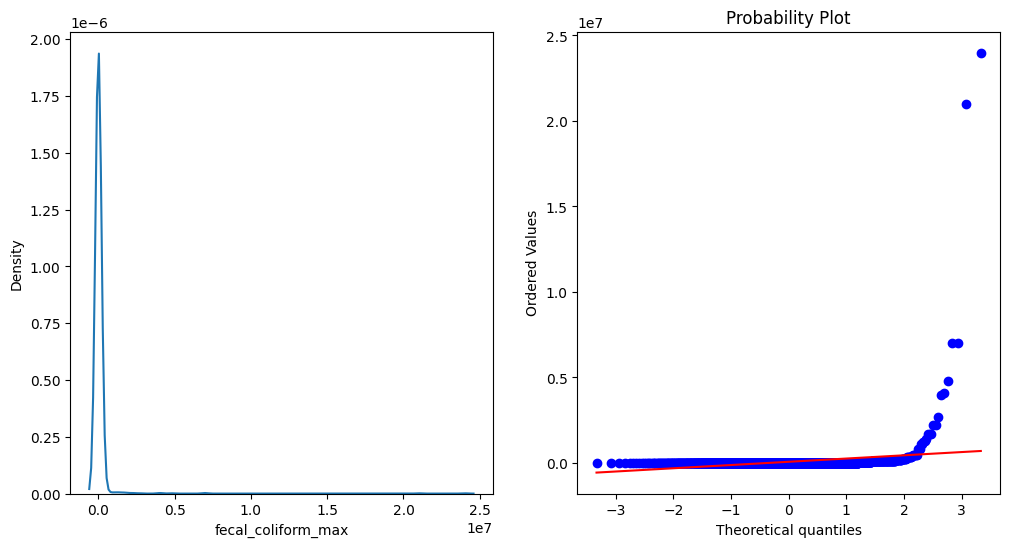

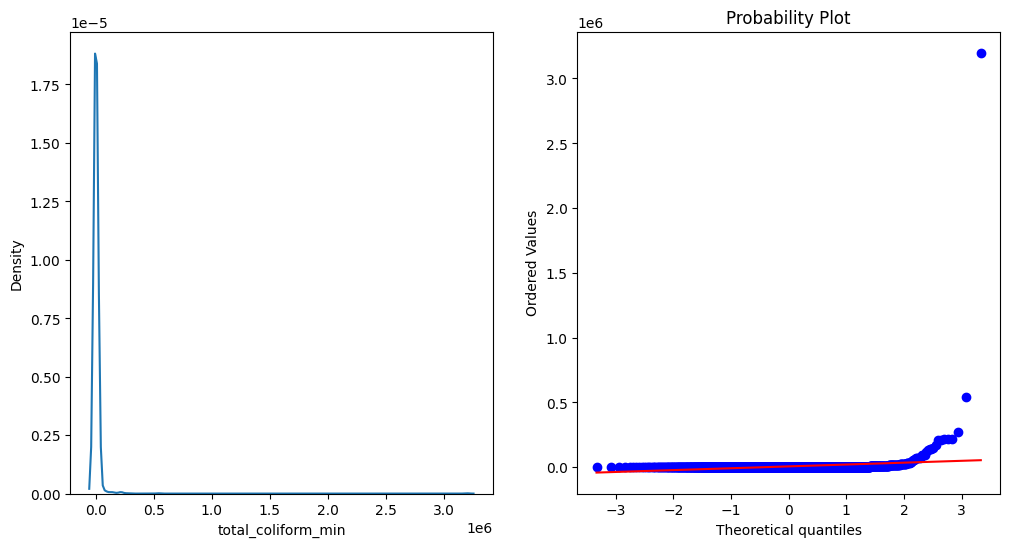

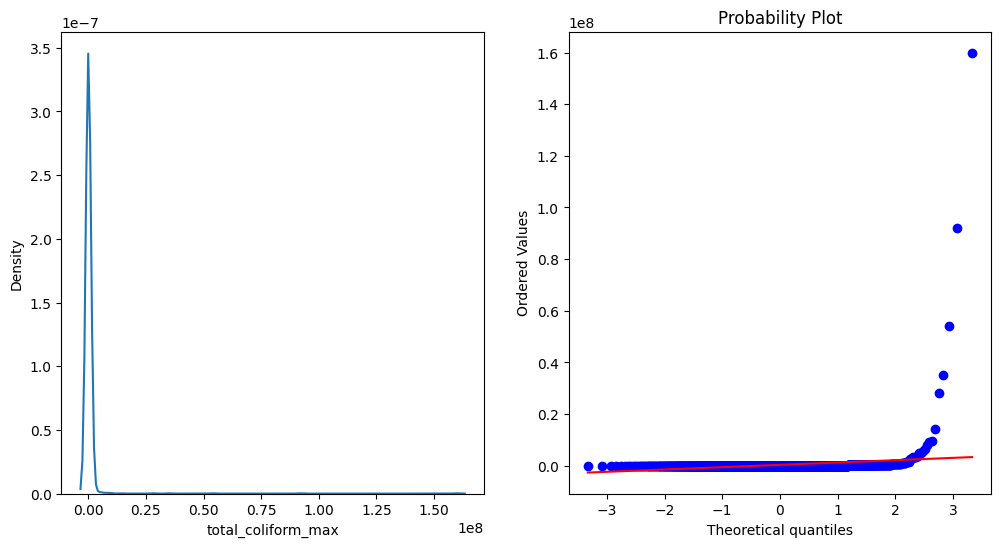

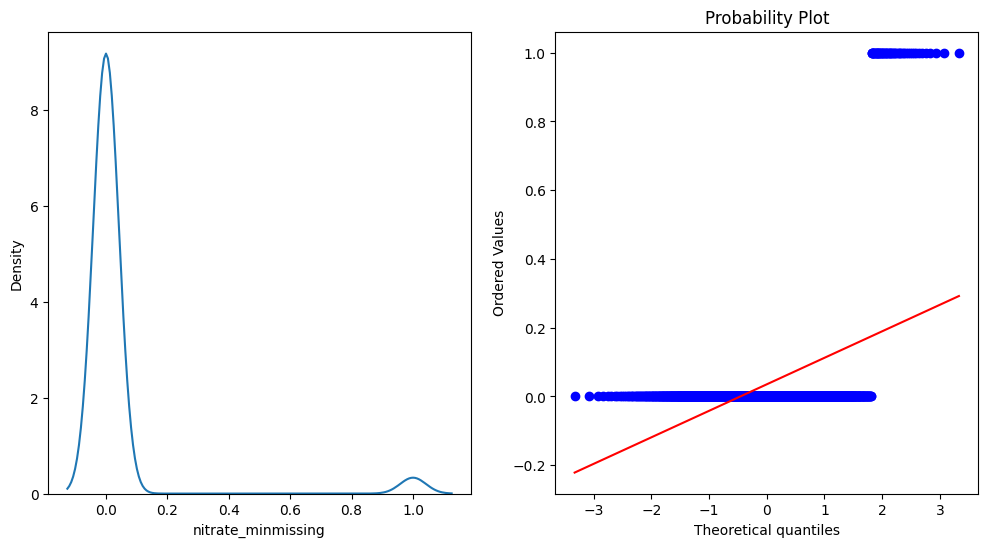

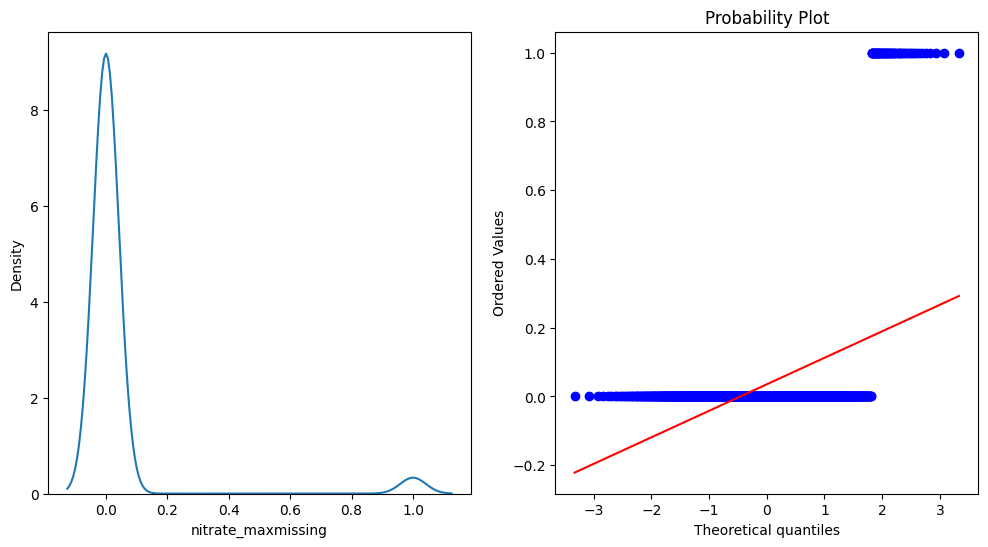

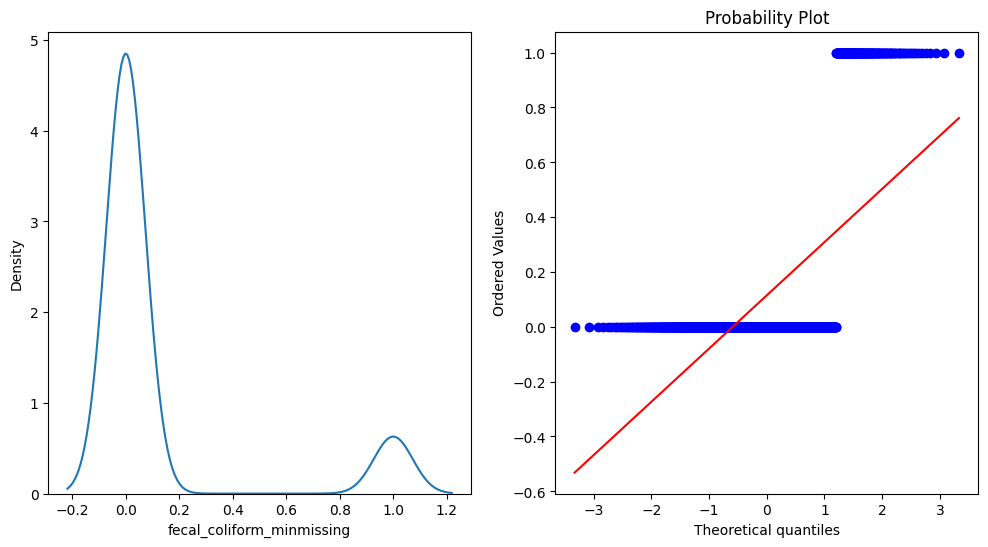

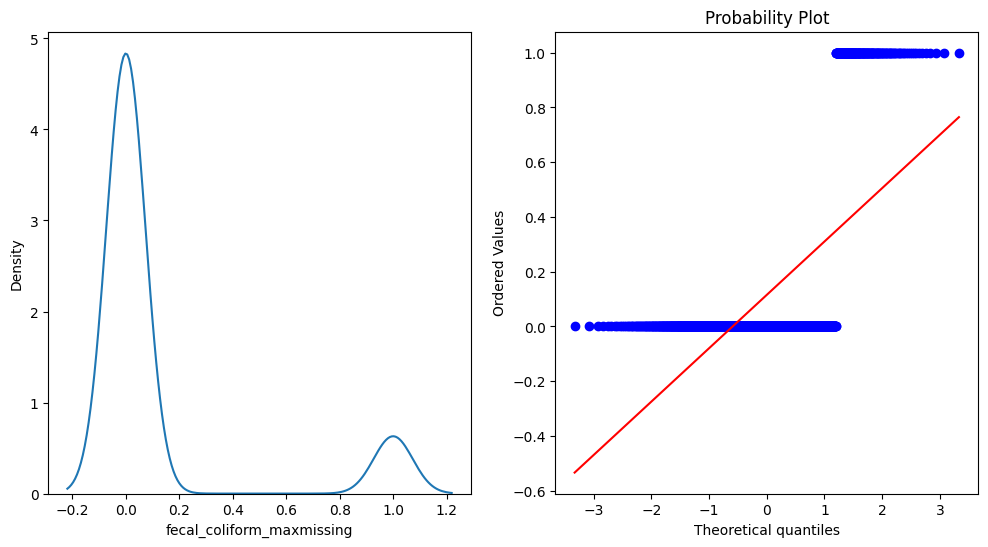

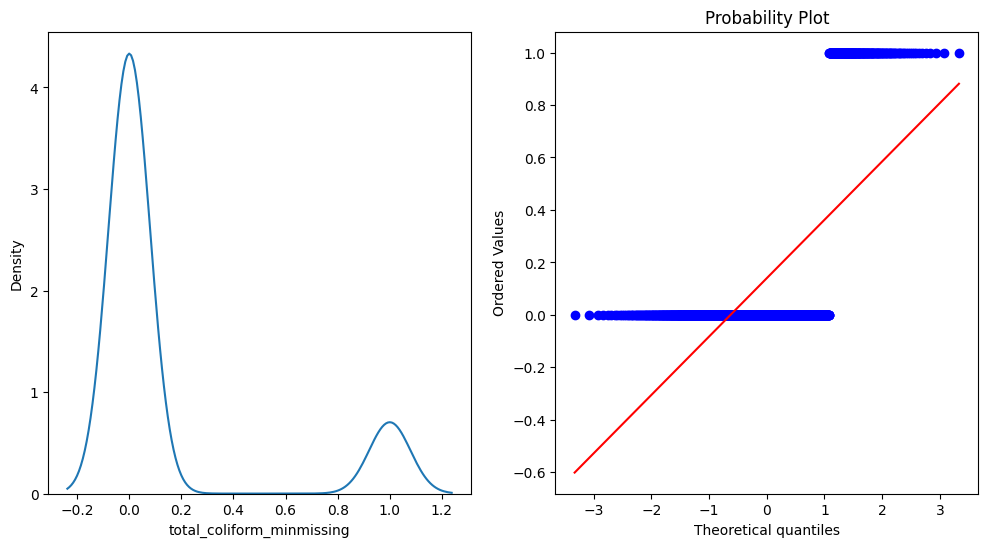

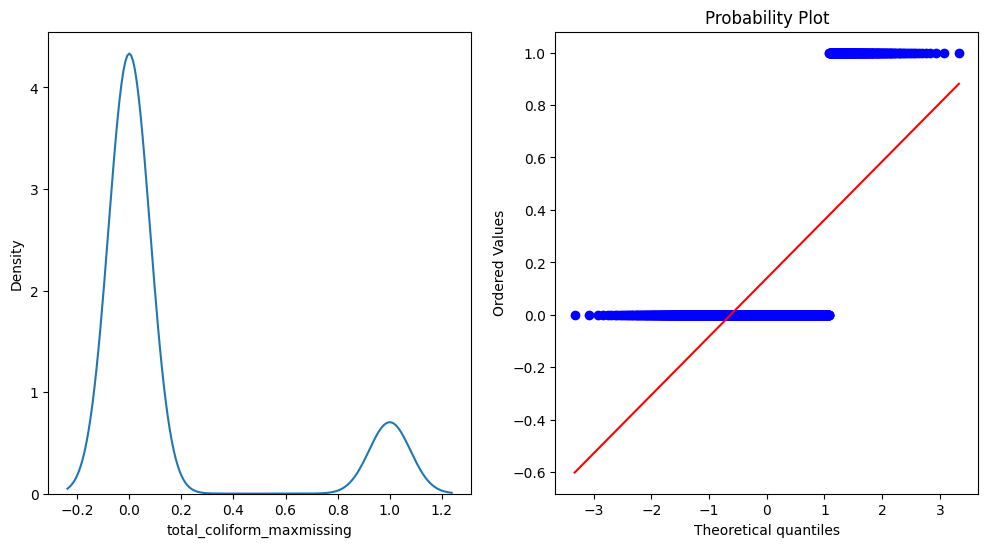

In [86]:
from scipy import stats as stats

for col in df.select_dtypes(np.number).columns:
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
    sns.kdeplot(df, x=col, ax=ax1)
    stats.probplot(df[col], dist='norm', plot=ax2)
    plt.show()

In [87]:
df[['temp_min', 'do_min', 'do_max', 'ph_min', 'ph_max', 'conductivity_min', 'conductivity_max', 'bod_min', 'bod_max','nitrate_min', 'nitrate_max', 'fecal_coliform_min', 'fecal_coliform_max', 'total_coliform_min', 'total_coliform_max']] = df[['temp_min', 'do_min', 'do_max', 'ph_min', 'ph_max', 'conductivity_min', 'conductivity_max', 'bod_min', 'bod_max','nitrate_min', 'nitrate_max', 'fecal_coliform_min', 'fecal_coliform_max', 'total_coliform_min', 'total_coliform_max']].apply(np.log1p) # type: ignore

In [88]:
df[['temp_min', 'ph_min', 'ph_max', 'bod_min', 'bod_max', 'nitrate_min', 'nitrate_max']] = df[['temp_min', 'ph_min', 'ph_max', 'bod_min', 'bod_max', 'nitrate_min', 'nitrate_max']].apply(np.log1p)

In [89]:
df.to_csv("./stations_cleaned.csv", index=False)

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1605 entries, 0 to 1610
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   station_code               1605 non-null   int64  
 1   monitoring_location        1599 non-null   object 
 2   state_name                 1481 non-null   object 
 3   temp_min                   1598 non-null   float64
 4   temp_max                   1597 non-null   float64
 5   do_min                     1597 non-null   float64
 6   do_max                     1597 non-null   float64
 7   ph_min                     1597 non-null   float64
 8   ph_max                     1597 non-null   float64
 9   conductivity_min           1597 non-null   float64
 10  conductivity_max           1597 non-null   float64
 11  bod_min                    1597 non-null   float64
 12  bod_max                    1597 non-null   float64
 13  nitrate_min                1605 non-null   float64
 1

In [91]:
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import SVC

In [93]:
df = df.sort_values('station_code')
df['is_pollution_mixing_point'] = 0

In [94]:
pollutant_cols = [
    'bod_max', 'nitrate_max', 'fecal_coliform_max', 'ph_max', 'conductivity_max',
]

In [ ]:
for i in range(1, len(df)):
    if df.iloc[i]['station_code'] == df.iloc[i-1]['station_code']:
        for col in pollutant_cols:
            if df.iloc[i][col] > df.iloc[i-1][col] * 1.5:
                df.at[df.index[i], 'is_pollution_mixing_point'] = 1